In [1]:
import numpy as np
import torch
import random

from q_probe import sweep_utils

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

/n/home01/dbrandfonbrener/conda/envs/mcts-llm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
# Paths for code llama on MBPP
train_path = "/n/holyscratch01/kempner_dev/Shared/mcts-llm/samples/14765178"
test_path = "/n/holyscratch01/kempner_dev/Shared/mcts-llm/samples/13643197"
he_path = "/n/holyscratch01/kempner_dev/Shared/mcts-llm/samples/17018932"
data_size = 200
n_val = 200

# Load data
(
    train_sample_dict,
    val_sample_dict,
    test_sample_dict,
    he_sample_dict,
) = sweep_utils.load_samples_to_dict(train_path, test_path, he_path, n_val=n_val)

In [4]:
print("Val size:", len(val_sample_dict), len(val_sample_dict[0]))
print("Test size:", len(test_sample_dict), len(test_sample_dict[0]))
print("HE size:", len(he_sample_dict), len(he_sample_dict[0]))

Val size: 464 200
Test size: 500 200
HE size: 164 200


In [103]:
probes = {}
for loss in ["pg", "mse", "ce"]:
    # Default settings
    probe_config = {
        "layer": 1,
        "lr": 5e-5,
        "weight_decay": 0.0,
        "num_epochs": 150,
        "tr_pctg": 1.0,
        "batch_size": 1000,
        "loss": loss,
        "chunk_size": 10,
        "temperature": 0.01,
        "seed": seed,
    }
    if probe_config["loss"] == "pg":
        probe_config["batch_size"] //= probe_config["chunk_size"]

    
    if probe_config["loss"] == "pg":
        train_data = sweep_utils.get_pg_train_data(train_sample_dict, data_size)
        print("Train size:", len(train_data), train_data[0][0].shape)
    else:
        train_data = sweep_utils.get_mse_train_data(train_sample_dict, data_size)
        print("Train size:", len(train_data), len(train_data[0]))

    probe = sweep_utils.train(probe_config, train_data)
    probes[loss] = probe

Mean of means: 0.3399245689655173
Train size: 464 (200, 4096)


Training probe, validation loss now = -0.2701, train loss = -0.2215: 100%|██████████| 150/150 [00:09<00:00, 15.39it/s]


Train size: 92800 2


Training probe, validation accuracy now = 84.15%, train accuracy = 84.15%: 100%|██████████| 150/150 [00:10<00:00, 14.64it/s]


Train size: 92800 2


Training probe, validation accuracy now = 84.77%, train accuracy = 84.77%: 100%|██████████| 150/150 [00:09<00:00, 15.02it/s]


In [121]:
sample_dict = train_sample_dict

In [122]:
# Compare easiness of problem with probe score on problem
losses = ["pg", "ce", "mse"]

per_problem_means = []
for idx in sample_dict.keys():
    sample_list = sample_dict[idx]
    per_problem_means.append(np.mean([s["reward"] for s in sample_list]))

per_problem_scores = {l: [] for l in losses}
all_scores = {l: [] for l in losses}
for loss in losses:
    for idx in sample_dict.keys():
        features = np.stack([s["features"] for s in sample_dict[idx]])
        values = probes[loss].get_value(features)
        per_problem_scores[loss].append( np.mean(values)  )
        all_scores[loss].extend(values)

    all_scores[loss] = np.array(all_scores[loss]).flatten()

In [123]:
repeat_means = []
for p in per_problem_means:
    repeat_means.extend([p]*200)

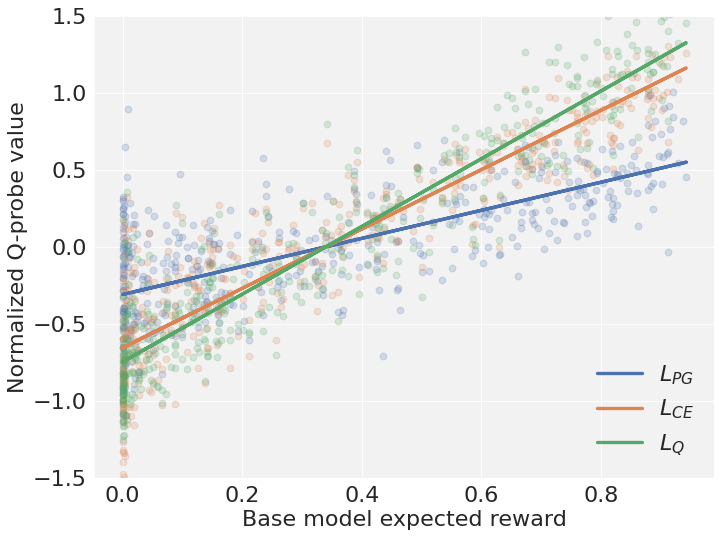

In [124]:
fs = 20
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
fig, ax =plt.subplots(figsize=(10, 7.5), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams['font.size'] = fs

colors = sns.color_palette('deep', n_colors=3)
losses = ["pg", "ce", "mse"]

labels = {"pg": "$L_{PG}$", "ce": "$L_{CE}$", "mse": "$L_Q$"}

for loss, color in zip(losses, colors):
    scores = (per_problem_scores[loss] - np.mean(all_scores[loss])) / np.std(all_scores[loss])
    plt.scatter(per_problem_means, scores, alpha=0.2, color=color)
    z = np.polyfit(per_problem_means, scores, 1)
    p = np.poly1d(z)
    plt.plot(per_problem_means, p(per_problem_means), label=labels[loss], color=color, linestyle="-", linewidth=3)


plt.xlabel("Base model expected reward")
plt.ylabel("Normalized Q-probe value")
plt.legend(frameon=False)
plt.ylim(-1.5,1.5)
plt.show()